# Cerinta 0 - Mediul

In [1]:
from os.path import expanduser, basename
from math import inf


class Environment:
    def __init__(self, input_file):
        self.neighbours = {}
        self.nodes = {}
        self.obsts = set()
        self.min_cost = inf
        self.__max_x = -inf
        self.__max_y = -inf

        delim = ", "
        obst = "obstacle"

        with open(expanduser(input_file)) as f:
            self.__mouse_x, self.__mouse_y = \
                [int(x) for x in next(f).split(delim)]
            self.__cheese_x, self.__cheese_y = \
                [int(x) for x in next(f).split(delim)]

            num_nodes = int(next(f))

            for _ in range(num_nodes):
                node = next(f).strip().split(delim)

                if obst not in node:
                    self.add_node(*list(map(int, node)))
                else:
                    self.add_node(*list(map(int, node[:-1])), True)

            num_edges = int(next(f))
            for _ in range(num_edges):
                self.add_edge(*list(map(int, next(f).strip().split(delim))))

    def add_node(self, id, pos_x, pos_y, obst=False):
        if pos_x == self.__mouse_x and pos_y == self.__mouse_y:
            self.start = id
        if pos_x == self.__cheese_x and pos_y == self.__cheese_y:
            self.target = id

        if self.__max_x < pos_x:
            self.__max_x = pos_x
        if self.__max_y < pos_y:
            self.__max_y = pos_y

        if obst:
            self.obsts.add((pos_x, pos_y))
        else:
            self.nodes[id] = (pos_x, pos_y)

    def add_edge(self, id1, id2, cost):
        if id1 not in self.nodes or id2 not in self.nodes:
            return

        if cost < self.min_cost:
            self.min_cost = cost

        if id1 in self.neighbours:
            self.neighbours[id1].append((id2, cost))
        else:
            self.neighbours[id1] = [(id2, cost)]

        if id2 in self.neighbours:
            self.neighbours[id2].append((id1, cost))
        else:
            self.neighbours[id2] = [(id1, cost)]

    def get_size(self):
        return (self.__max_x + 1, self.__max_y + 1)


# Functii inutile pentru rezolvare, dar 5p sunt 5p...
def init_env(input_file):
    return Environment(input_file)


def get_next_states(env, state):
    return env.neigbours[state]


def apply_action(env, state, action):
    pass

# Cerinta 4 - Euristica weighthattan si altele pentru comparatie

In [2]:
from math import sqrt


def manhattan(env, node):
    target = env.nodes[env.target]
    crt = env.nodes[node]

    return abs(crt[0] - target[0]) + abs(crt[1] - target[1])


def euclid(env, node):
    target = env.nodes[env.target]
    crt = env.nodes[node]

    return int(sqrt((crt[0] - target[0])**2 + (crt[1] - target[1])**2))


def weighthattan(env, node):
    return manhattan(env, node) * env.min_cost

## Variabile globale

In [3]:
INPUT_FILES = ["inputs/input1.txt", "inputs/input2.txt", "inputs/input3.txt"]

HEURISTICS = {
    "euclid": euclid,
    "manhattan": manhattan,
    "weighthattan": weighthattan
}

ENVS = {file: Environment(file) for file in INPUT_FILES}

PERFORMANCE_METRICS = {
    "DFID": {},
    "IDA*": {basename(file): {} for file in INPUT_FILES},
    "LRTA*": {basename(file): {} for file in INPUT_FILES},
    "BnB": {basename(file): {} for file in INPUT_FILES},
}

## Functii pentru afisarea rezultatelor

In [4]:
import matplotlib.pyplot as plt


plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)


def _get_real_path(path, env):
    return " -> ".join([f"{env.nodes[node]}" for node in path])


def _plot_costs(axis, map_size, env, costs):
    visited_costs = {env.nodes[node]: cost for node, cost in costs.items()}
    cost_map = [[visited_costs.get((c, r), 0)
        for r in range(map_size[0])] for c in range(map_size[1])]

    for r in range(map_size[0]):
        for c in range(map_size[1]):
            if (c, r) in env.obsts:
                cost_map[c][r] = -20

    axis.set_title("Costurile gasite de agent", fontsize=20)
    axis.imshow(cost_map, cmap="gist_heat", interpolation="nearest",
        origin="lower")


def _plot_path(axis, map_size, env, path):
    visited = set(env.nodes[node] for node in path)
    cost_map = [[0 if (c, r) in env.obsts else 20 \
        for r in range(map_size[0])] for c in range(map_size[1])]

    for r in range(map_size[0]):
        for c in range(map_size[1]):
            if (c, r) in visited:
                cost_map[c][r] = 40

    cost_map[env.nodes[env.target][0]][env.nodes[env.target][1]] = 60
    cost_map[env.nodes[env.start][0]][env.nodes[env.start][1]] = 30

    axis.set_title("Calea agentului pana la tinta", fontsize=20)
    axis.imshow(cost_map, cmap="gist_heat", interpolation="nearest",
        origin="lower")


def display_results(alg, input_file, env, path, costs, time, memory,
    heur_name=None
):
    print(f"Nodurile din calea gasita:\n{path}")
    print(f"Pozitiile din calea gasita:\n{_get_real_path(path, env)}")

    print(f"Costul pana la tinta: {costs[env.target]}")
    print(f"Timpul de rulare: {time} s")
    print(f"Memoria utilizata: {memory / 2**10} KB")

    map_size = env.get_size()
    _, axes = plt.subplots(1, 2, figsize=(15, 15))

    _plot_costs(axes[0], map_size, env, costs)
    _plot_path(axes[1], map_size, env, path)

    plt.show()

## Functie pentru rularea unui algoritm si masurarea performantelor acestuia

In [5]:
from time import process_time
import tracemalloc


def run(alg, alg_name, input_file, heur=None, heur_name=None):
    env = ENVS[input_file]

    # Algoritmul e rulat de 2 ori, deoarece hookurile facute de `tracemalloc`
    # incetinesc algoritmul, ceea ce corupe masuratoarea de timp
    # De asemenea, e necesar ca rularea pentru masurarea memoriei sa se faca
    # prima. In caz contrar, masuratorile vor arata valori mai mici, deoarece
    # se va refolosi o parte din memoria alocata in cadrul primei rulari a
    # algoritmului.

    tracemalloc.start()

    if heur:
        path, costs = alg(env, heur)
    else:
        path, costs = alg(env)

    # Cantitatea maxima de memorie utilizata
    memory = tracemalloc.get_traced_memory()[1]
    tracemalloc.stop()

    start_time = process_time()

    if heur:
        path, costs = alg(env, heur)
    else:
        path, costs = alg(env)

    end_time = process_time()
    running_time = end_time - start_time

    display_results(alg_name, input_file, env, path, costs, running_time,
        memory, heur_name)
    
    return running_time, memory / 2**10

# Cerinta 1 - Depth First Iterative Deepening

============================== DFID pe input1.txt ==============================
Nodurile din calea gasita:
[20, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 18, 27, 36, 45, 55, 64, 73, 82]
Pozitiile din calea gasita:
(2, 0) -> (1, 0) -> (0, 0) -> (0, 1) -> (0, 2) -> (0, 3) -> (0, 4) -> (0, 5) -> (0, 6) -> (0, 7) -> (0, 8) -> (1, 8) -> (2, 8) -> (3, 8) -> (4, 8) -> (5, 8) -> (6, 8) -> (7, 8) -> (8, 8)
Costul pana la tinta: 18
Timpul de rulare: 0.0008667549999998858 s
Memoria utilizata: 14.2138671875 KB


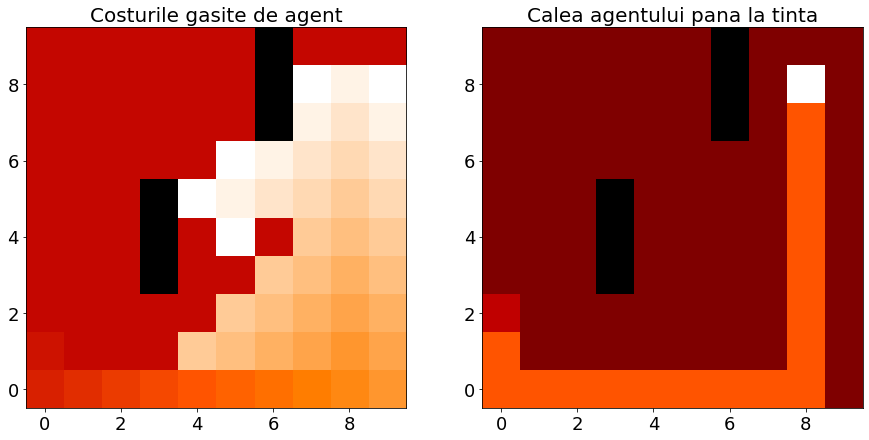



============================== DFID pe input2.txt ==============================
Nodurile din calea gasita:
[252, 233, 214, 215, 199, 179, 178, 167, 147, 146, 145, 144, 143, 142, 141, 140, 139, 129, 113, 112, 111, 110, 91, 75, 76, 77, 78, 79, 60, 43, 24, 25, 26, 27, 28, 29, 30, 31]
Pozitiile din calea gasita:
(14, 12) -> (13, 12) -> (12, 12) -> (12, 13) -> (11, 13) -> (10, 13) -> (10, 12) -> (9, 12) -> (8, 12) -> (8, 11) -> (8, 10) -> (8, 9) -> (8, 8) -> (8, 7) -> (8, 6) -> (8, 5) -> (8, 4) -> (7, 4) -> (6, 4) -> (6, 3) -> (6, 2) -> (6, 1) -> (5, 1) -> (4, 1) -> (4, 2) -> (4, 3) -> (4, 4) -> (4, 5) -> (3, 5) -> (2, 5) -> (1, 5) -> (1, 6) -> (1, 7) -> (1, 8) -> (1, 9) -> (1, 10) -> (1, 11) -> (1, 12)
Costul pana la tinta: 89
Timpul de rulare: 0.018943809000000034 s
Memoria utilizata: 35.2724609375 KB


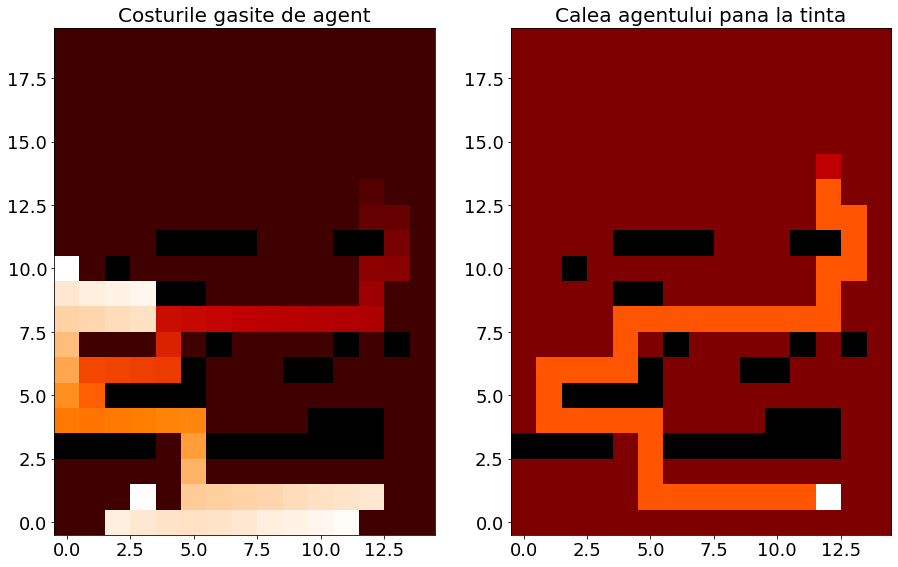



============================== DFID pe input3.txt ==============================
Nodurile din calea gasita:
[1, 2, 3, 4, 5, 35, 65, 95, 125, 155, 185, 215, 245, 275, 305, 335, 365, 395, 425, 455, 485, 515, 545, 575, 605, 635, 665, 695, 725, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 736, 706, 676, 646, 645, 644, 643, 613, 583, 553, 554, 555, 556, 557, 558, 559, 560]
Pozitiile din calea gasita:
(0, 0) -> (0, 1) -> (0, 2) -> (0, 3) -> (0, 4) -> (1, 4) -> (2, 4) -> (3, 4) -> (4, 4) -> (5, 4) -> (6, 4) -> (7, 4) -> (8, 4) -> (9, 4) -> (10, 4) -> (11, 4) -> (12, 4) -> (13, 4) -> (14, 4) -> (15, 4) -> (16, 4) -> (17, 4) -> (18, 4) -> (19, 4) -> (20, 4) -> (21, 4) -> (22, 4) -> (23, 4) -> (24, 4) -> (25, 4) -> (25, 5) -> (25, 6) -> (25, 7) -> (25, 8) -> (25, 9) -> (25, 10) -> (25, 11) -> (25, 12) -> (25, 13) -> (25, 14) -> (25, 15) -> (24, 15) -> (23, 15) -> (22, 15) -> (21, 15) -> (21, 14) -> (21, 13) -> (21, 12) -> (20, 12) -> (19, 12) -> (18, 12) -> (18, 13) -> (18, 14) 

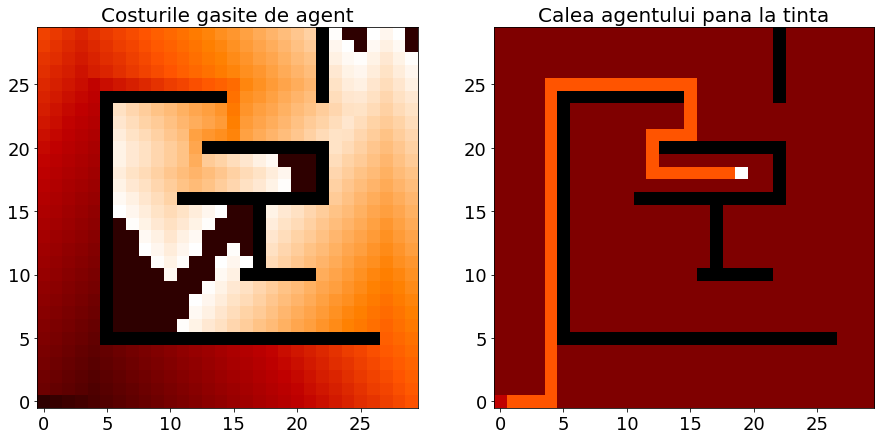

In [6]:
def _dfid_traversal(env, node, visited, crt_cost, limit):
    global global_limit

    if node == env.target:
        return [node]

    for neigh, new_cost in env.neighbours[node]:
        neigh_cost = crt_cost + new_cost

        if neigh in visited and neigh_cost >= visited[neigh]:
            continue

        visited[neigh] = neigh_cost

        if neigh_cost <= limit:
            next_path = _dfid_traversal(env, neigh, visited,
                neigh_cost, limit)

            if next_path:
                return [node] + next_path
        elif neigh_cost < global_limit:
            global_limit = neigh_cost

    return []


def dfid(env):
    global global_limit

    global_limit = 0
    best_path = []
    visited = {}

    while not best_path and global_limit != inf:
        limit = global_limit
        global_limit = inf
        visited = {env.start: 0}

        best_path = _dfid_traversal(env, env.start, visited, 0, limit)

    return best_path, visited


for file in INPUT_FILES:
    print(f"============================== DFID pe {basename(file)} ==============================")
    
    PERFORMANCE_METRICS["DFID"][basename(file)] = run(dfid, "DFID", file)

    print("\n")

# Cerinta 2 - Iterative Deepening A*

============================== IDA* pe input1.txt cu euristica Euclid ==============================
Nodurile din calea gasita:
[20, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 18, 27, 36, 45, 55, 64, 73, 82]
Pozitiile din calea gasita:
(2, 0) -> (1, 0) -> (0, 0) -> (0, 1) -> (0, 2) -> (0, 3) -> (0, 4) -> (0, 5) -> (0, 6) -> (0, 7) -> (0, 8) -> (1, 8) -> (2, 8) -> (3, 8) -> (4, 8) -> (5, 8) -> (6, 8) -> (7, 8) -> (8, 8)
Costul pana la tinta: 18
Timpul de rulare: 0.0009615400000000385 s
Memoria utilizata: 12.2294921875 KB


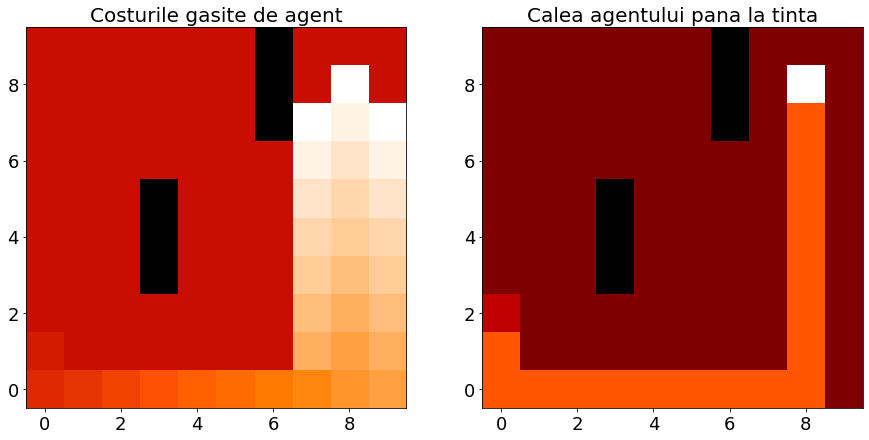



============================== IDA* pe input1.txt cu euristica Manhattan ==============================
Nodurile din calea gasita:
[20, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 18, 27, 36, 45, 55, 64, 73, 82]
Pozitiile din calea gasita:
(2, 0) -> (1, 0) -> (0, 0) -> (0, 1) -> (0, 2) -> (0, 3) -> (0, 4) -> (0, 5) -> (0, 6) -> (0, 7) -> (0, 8) -> (1, 8) -> (2, 8) -> (3, 8) -> (4, 8) -> (5, 8) -> (6, 8) -> (7, 8) -> (8, 8)
Costul pana la tinta: 18
Timpul de rulare: 0.0001312160000002116 s
Memoria utilizata: 6.1484375 KB


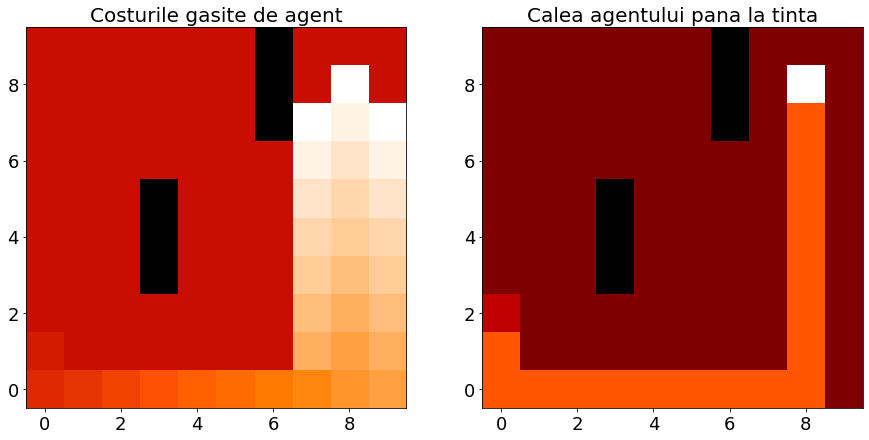



============================== IDA* pe input1.txt cu euristica Weighthattan ==============================
Nodurile din calea gasita:
[20, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 18, 27, 36, 45, 55, 64, 73, 82]
Pozitiile din calea gasita:
(2, 0) -> (1, 0) -> (0, 0) -> (0, 1) -> (0, 2) -> (0, 3) -> (0, 4) -> (0, 5) -> (0, 6) -> (0, 7) -> (0, 8) -> (1, 8) -> (2, 8) -> (3, 8) -> (4, 8) -> (5, 8) -> (6, 8) -> (7, 8) -> (8, 8)
Costul pana la tinta: 18
Timpul de rulare: 0.00014620799999987 s
Memoria utilizata: 5.1015625 KB


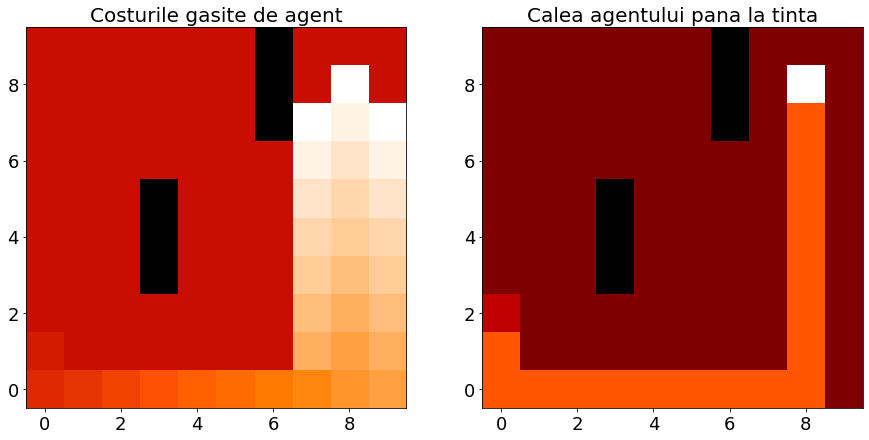



============================== IDA* pe input2.txt cu euristica Euclid ==============================
Nodurile din calea gasita:
[252, 233, 214, 215, 199, 179, 178, 167, 147, 146, 145, 144, 143, 142, 141, 140, 139, 129, 113, 112, 111, 110, 91, 75, 76, 77, 78, 79, 60, 43, 24, 25, 26, 27, 28, 29, 30, 31]
Pozitiile din calea gasita:
(14, 12) -> (13, 12) -> (12, 12) -> (12, 13) -> (11, 13) -> (10, 13) -> (10, 12) -> (9, 12) -> (8, 12) -> (8, 11) -> (8, 10) -> (8, 9) -> (8, 8) -> (8, 7) -> (8, 6) -> (8, 5) -> (8, 4) -> (7, 4) -> (6, 4) -> (6, 3) -> (6, 2) -> (6, 1) -> (5, 1) -> (4, 1) -> (4, 2) -> (4, 3) -> (4, 4) -> (4, 5) -> (3, 5) -> (2, 5) -> (1, 5) -> (1, 6) -> (1, 7) -> (1, 8) -> (1, 9) -> (1, 10) -> (1, 11) -> (1, 12)
Costul pana la tinta: 89
Timpul de rulare: 0.06255052000000028 s
Memoria utilizata: 21.7958984375 KB


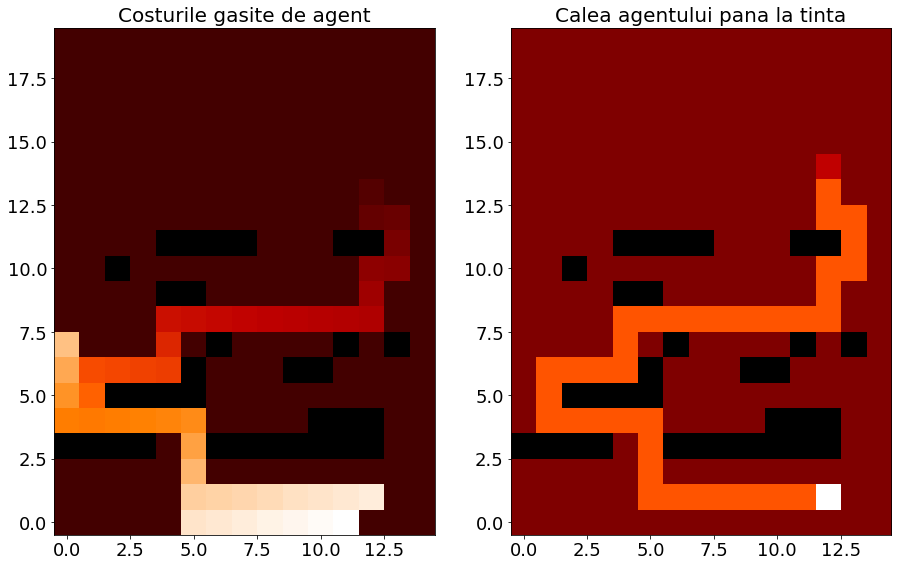



============================== IDA* pe input2.txt cu euristica Manhattan ==============================
Nodurile din calea gasita:
[252, 233, 214, 215, 199, 179, 178, 167, 147, 146, 145, 144, 143, 142, 141, 140, 139, 129, 113, 112, 111, 110, 91, 75, 76, 77, 78, 79, 60, 43, 24, 25, 26, 27, 28, 29, 30, 31]
Pozitiile din calea gasita:
(14, 12) -> (13, 12) -> (12, 12) -> (12, 13) -> (11, 13) -> (10, 13) -> (10, 12) -> (9, 12) -> (8, 12) -> (8, 11) -> (8, 10) -> (8, 9) -> (8, 8) -> (8, 7) -> (8, 6) -> (8, 5) -> (8, 4) -> (7, 4) -> (6, 4) -> (6, 3) -> (6, 2) -> (6, 1) -> (5, 1) -> (4, 1) -> (4, 2) -> (4, 3) -> (4, 4) -> (4, 5) -> (3, 5) -> (2, 5) -> (1, 5) -> (1, 6) -> (1, 7) -> (1, 8) -> (1, 9) -> (1, 10) -> (1, 11) -> (1, 12)
Costul pana la tinta: 89
Timpul de rulare: 0.019768216999999755 s
Memoria utilizata: 10.2021484375 KB


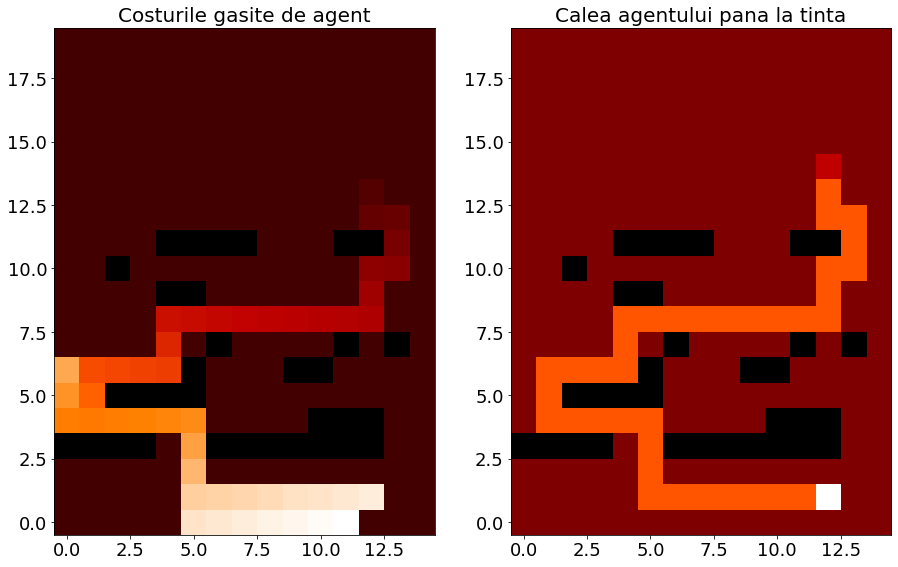



============================== IDA* pe input2.txt cu euristica Weighthattan ==============================
Nodurile din calea gasita:
[252, 233, 214, 215, 199, 179, 178, 167, 147, 146, 145, 144, 143, 142, 141, 140, 139, 129, 113, 112, 111, 110, 91, 75, 76, 77, 78, 79, 60, 43, 24, 25, 26, 27, 28, 29, 30, 31]
Pozitiile din calea gasita:
(14, 12) -> (13, 12) -> (12, 12) -> (12, 13) -> (11, 13) -> (10, 13) -> (10, 12) -> (9, 12) -> (8, 12) -> (8, 11) -> (8, 10) -> (8, 9) -> (8, 8) -> (8, 7) -> (8, 6) -> (8, 5) -> (8, 4) -> (7, 4) -> (6, 4) -> (6, 3) -> (6, 2) -> (6, 1) -> (5, 1) -> (4, 1) -> (4, 2) -> (4, 3) -> (4, 4) -> (4, 5) -> (3, 5) -> (2, 5) -> (1, 5) -> (1, 6) -> (1, 7) -> (1, 8) -> (1, 9) -> (1, 10) -> (1, 11) -> (1, 12)
Costul pana la tinta: 89
Timpul de rulare: 0.01763617900000014 s
Memoria utilizata: 10.2412109375 KB


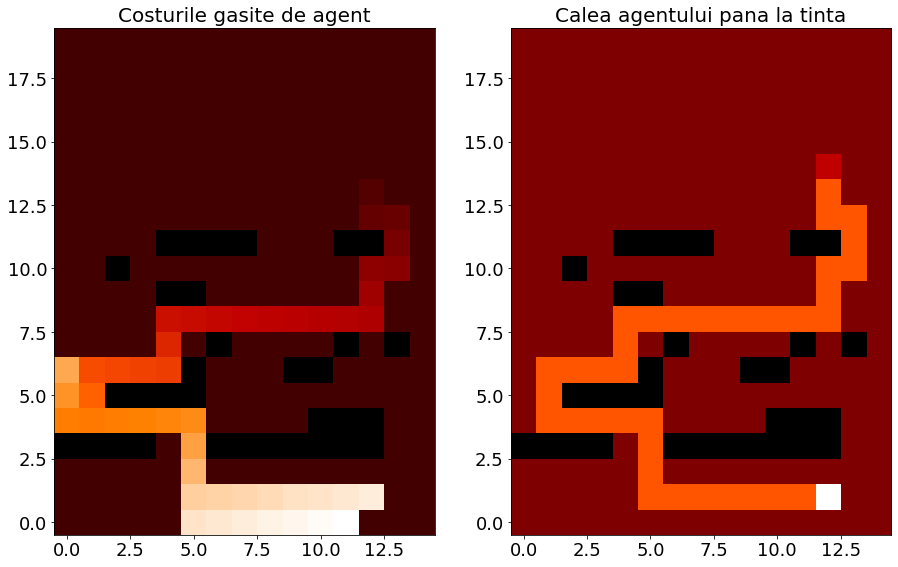



============================== IDA* pe input3.txt cu euristica Euclid ==============================
Nodurile din calea gasita:
[1, 2, 3, 4, 5, 35, 65, 95, 125, 155, 185, 215, 245, 275, 305, 335, 365, 395, 425, 455, 485, 515, 545, 575, 605, 635, 665, 695, 725, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 736, 706, 676, 646, 645, 644, 643, 613, 583, 553, 554, 555, 556, 557, 558, 559, 560]
Pozitiile din calea gasita:
(0, 0) -> (0, 1) -> (0, 2) -> (0, 3) -> (0, 4) -> (1, 4) -> (2, 4) -> (3, 4) -> (4, 4) -> (5, 4) -> (6, 4) -> (7, 4) -> (8, 4) -> (9, 4) -> (10, 4) -> (11, 4) -> (12, 4) -> (13, 4) -> (14, 4) -> (15, 4) -> (16, 4) -> (17, 4) -> (18, 4) -> (19, 4) -> (20, 4) -> (21, 4) -> (22, 4) -> (23, 4) -> (24, 4) -> (25, 4) -> (25, 5) -> (25, 6) -> (25, 7) -> (25, 8) -> (25, 9) -> (25, 10) -> (25, 11) -> (25, 12) -> (25, 13) -> (25, 14) -> (25, 15) -> (24, 15) -> (23, 15) -> (22, 15) -> (21, 15) -> (21, 14) -> (21, 13) -> (21, 12) -> (20, 12) -> (19, 12) -> (18, 12) -> (

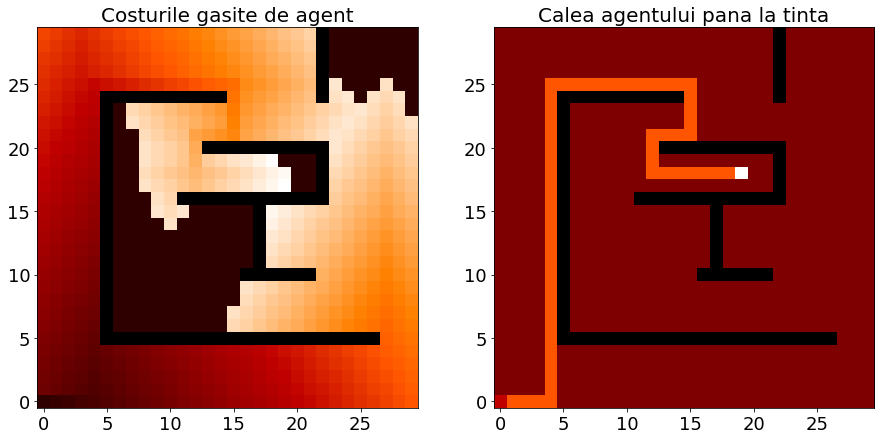



============================== IDA* pe input3.txt cu euristica Manhattan ==============================
Nodurile din calea gasita:
[1, 2, 3, 4, 5, 35, 65, 95, 125, 155, 185, 215, 245, 275, 305, 335, 365, 395, 425, 455, 485, 515, 545, 575, 605, 635, 665, 695, 725, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 736, 706, 676, 646, 645, 644, 643, 613, 583, 553, 554, 555, 556, 557, 558, 559, 560]
Pozitiile din calea gasita:
(0, 0) -> (0, 1) -> (0, 2) -> (0, 3) -> (0, 4) -> (1, 4) -> (2, 4) -> (3, 4) -> (4, 4) -> (5, 4) -> (6, 4) -> (7, 4) -> (8, 4) -> (9, 4) -> (10, 4) -> (11, 4) -> (12, 4) -> (13, 4) -> (14, 4) -> (15, 4) -> (16, 4) -> (17, 4) -> (18, 4) -> (19, 4) -> (20, 4) -> (21, 4) -> (22, 4) -> (23, 4) -> (24, 4) -> (25, 4) -> (25, 5) -> (25, 6) -> (25, 7) -> (25, 8) -> (25, 9) -> (25, 10) -> (25, 11) -> (25, 12) -> (25, 13) -> (25, 14) -> (25, 15) -> (24, 15) -> (23, 15) -> (22, 15) -> (21, 15) -> (21, 14) -> (21, 13) -> (21, 12) -> (20, 12) -> (19, 12) -> (18, 12) -

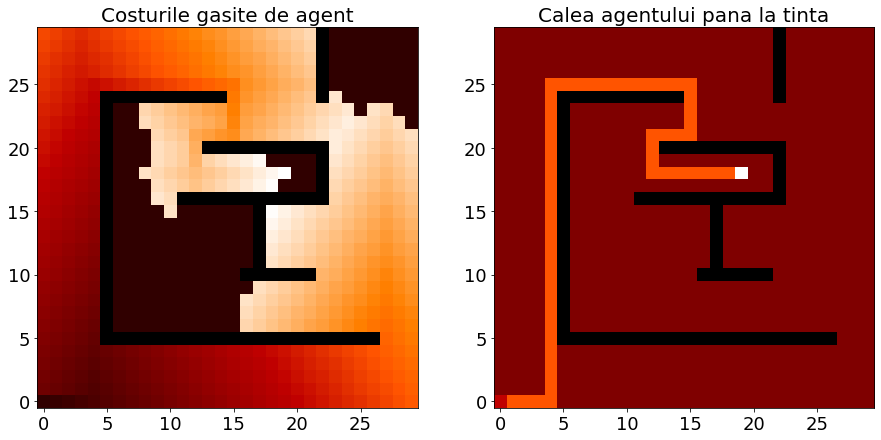



============================== IDA* pe input3.txt cu euristica Weighthattan ==============================
Nodurile din calea gasita:
[1, 2, 3, 4, 5, 35, 65, 95, 125, 155, 185, 215, 245, 275, 305, 335, 365, 395, 425, 455, 485, 515, 545, 575, 605, 635, 665, 695, 725, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 736, 706, 676, 646, 645, 644, 643, 613, 583, 553, 554, 555, 556, 557, 558, 559, 560]
Pozitiile din calea gasita:
(0, 0) -> (0, 1) -> (0, 2) -> (0, 3) -> (0, 4) -> (1, 4) -> (2, 4) -> (3, 4) -> (4, 4) -> (5, 4) -> (6, 4) -> (7, 4) -> (8, 4) -> (9, 4) -> (10, 4) -> (11, 4) -> (12, 4) -> (13, 4) -> (14, 4) -> (15, 4) -> (16, 4) -> (17, 4) -> (18, 4) -> (19, 4) -> (20, 4) -> (21, 4) -> (22, 4) -> (23, 4) -> (24, 4) -> (25, 4) -> (25, 5) -> (25, 6) -> (25, 7) -> (25, 8) -> (25, 9) -> (25, 10) -> (25, 11) -> (25, 12) -> (25, 13) -> (25, 14) -> (25, 15) -> (24, 15) -> (23, 15) -> (22, 15) -> (21, 15) -> (21, 14) -> (21, 13) -> (21, 12) -> (20, 12) -> (19, 12) -> (18, 12

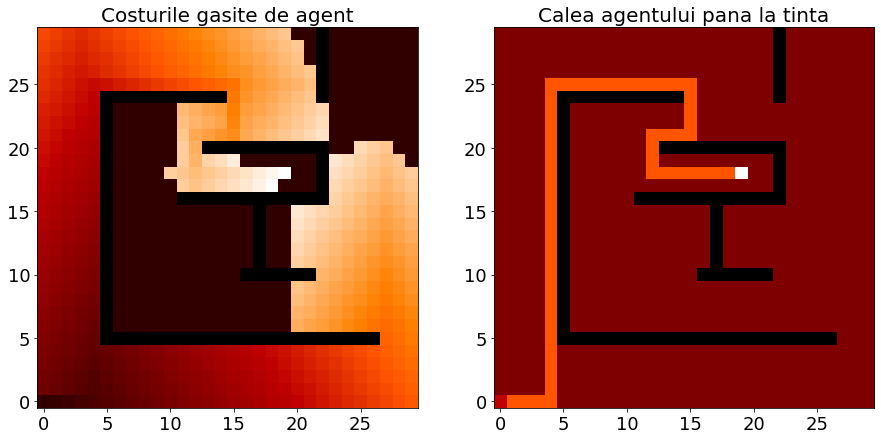

In [7]:
def _ida_traversal(env, node, visited, crt_cost, limit, h):
    global global_limit

    if node == env.target:
        return [node]

    for neigh, neigh_cost in env.neighbours[node]:
        real_neigh_cost = crt_cost + neigh_cost
        pred_neigh_cost = real_neigh_cost + h(env, neigh)

        if neigh in visited and real_neigh_cost >= visited[neigh]:
            continue

        visited[neigh] = real_neigh_cost

        if pred_neigh_cost <= limit:
            next_path = _ida_traversal(env, neigh, visited, real_neigh_cost,
                limit, h)

            if next_path:
                return [node] + next_path
        elif pred_neigh_cost < global_limit:
            global_limit = pred_neigh_cost

    return []


def ida(env, h):
    global global_limit

    global_limit = h(env, env.start)
    best_path = []
    visited = {}

    while not best_path and global_limit != inf:
        limit = global_limit
        global_limit = inf
        visited = {env.start: 0}

        best_path = _ida_traversal(env, env.start, visited, 0, limit, h)

    return best_path, visited


for file in INPUT_FILES:
    for h_name, h_func in HEURISTICS.items():
        print(f"============================== IDA* pe {basename(file)} cu euristica {h_name.capitalize()} ==============================")
        PERFORMANCE_METRICS["IDA*"][basename(file)][h_name] = run(ida, "IDA*", file, h_func, h_name)
        print("\n")

# Cerinta 3 - Learning Real-Time A*

============================== LRTA* pe input1.txt cu euristica Euclid ==============================
Nodurile din calea gasita:
[20, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 18, 27, 36, 45, 55, 64, 73, 82]
Pozitiile din calea gasita:
(2, 0) -> (1, 0) -> (0, 0) -> (0, 1) -> (0, 2) -> (0, 3) -> (0, 4) -> (0, 5) -> (0, 6) -> (0, 7) -> (0, 8) -> (1, 8) -> (2, 8) -> (3, 8) -> (4, 8) -> (5, 8) -> (6, 8) -> (7, 8) -> (8, 8)
Costul pana la tinta: 18
Timpul de rulare: 0.000636746000000521 s
Memoria utilizata: 6.46875 KB


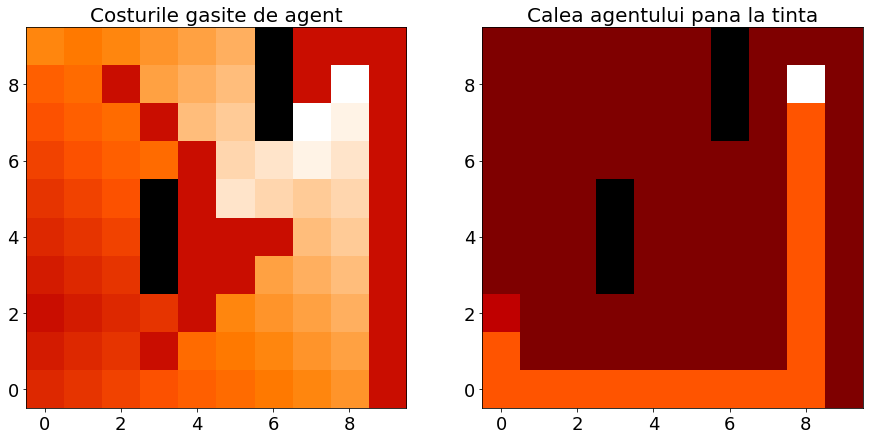



============================== LRTA* pe input1.txt cu euristica Manhattan ==============================
Nodurile din calea gasita:
[20, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 18, 27, 36, 45, 55, 64, 73, 82]
Pozitiile din calea gasita:
(2, 0) -> (1, 0) -> (0, 0) -> (0, 1) -> (0, 2) -> (0, 3) -> (0, 4) -> (0, 5) -> (0, 6) -> (0, 7) -> (0, 8) -> (1, 8) -> (2, 8) -> (3, 8) -> (4, 8) -> (5, 8) -> (6, 8) -> (7, 8) -> (8, 8)
Costul pana la tinta: 18
Timpul de rulare: 0.0005186070000000598 s
Memoria utilizata: 5.8984375 KB


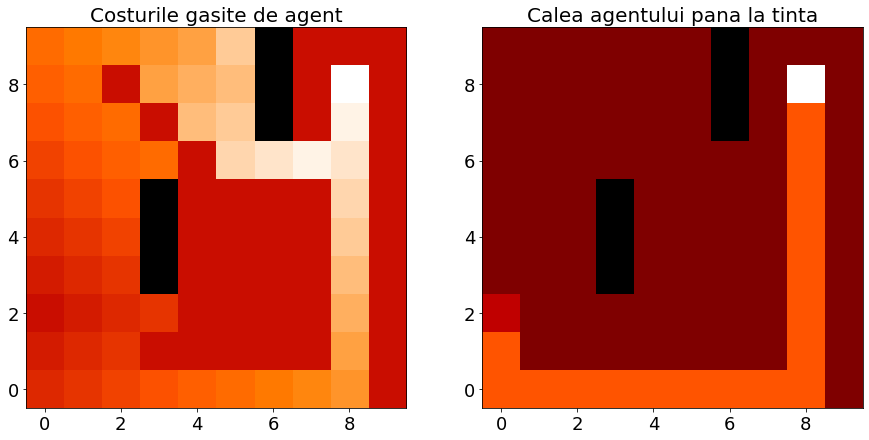



============================== LRTA* pe input1.txt cu euristica Weighthattan ==============================
Nodurile din calea gasita:
[20, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 18, 27, 36, 45, 55, 64, 73, 82]
Pozitiile din calea gasita:
(2, 0) -> (1, 0) -> (0, 0) -> (0, 1) -> (0, 2) -> (0, 3) -> (0, 4) -> (0, 5) -> (0, 6) -> (0, 7) -> (0, 8) -> (1, 8) -> (2, 8) -> (3, 8) -> (4, 8) -> (5, 8) -> (6, 8) -> (7, 8) -> (8, 8)
Costul pana la tinta: 18
Timpul de rulare: 0.0006337659999999801 s
Memoria utilizata: 5.8984375 KB


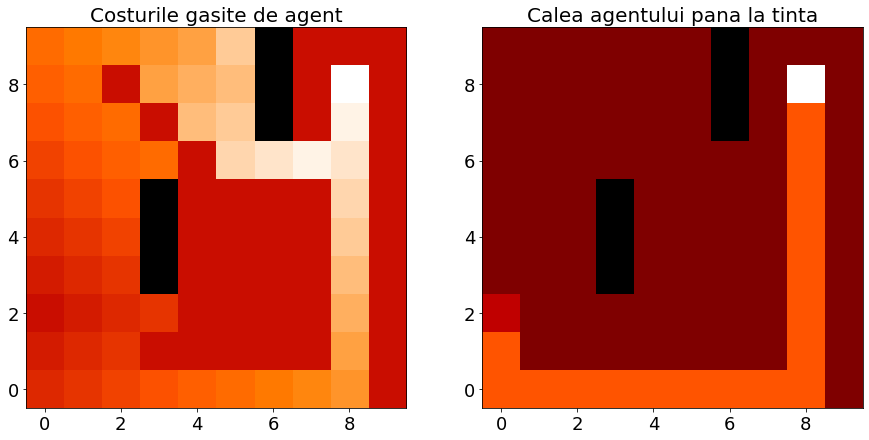



============================== LRTA* pe input2.txt cu euristica Euclid ==============================
Nodurile din calea gasita:
[252, 233, 214, 215, 199, 179, 178, 167, 147, 146, 145, 144, 143, 142, 141, 140, 139, 129, 113, 112, 111, 110, 91, 75, 76, 77, 78, 79, 60, 43, 24, 25, 26, 27, 28, 29, 30, 31]
Pozitiile din calea gasita:
(14, 12) -> (13, 12) -> (12, 12) -> (12, 13) -> (11, 13) -> (10, 13) -> (10, 12) -> (9, 12) -> (8, 12) -> (8, 11) -> (8, 10) -> (8, 9) -> (8, 8) -> (8, 7) -> (8, 6) -> (8, 5) -> (8, 4) -> (7, 4) -> (6, 4) -> (6, 3) -> (6, 2) -> (6, 1) -> (5, 1) -> (4, 1) -> (4, 2) -> (4, 3) -> (4, 4) -> (4, 5) -> (3, 5) -> (2, 5) -> (1, 5) -> (1, 6) -> (1, 7) -> (1, 8) -> (1, 9) -> (1, 10) -> (1, 11) -> (1, 12)
Costul pana la tinta: 89
Timpul de rulare: 0.007964525000000222 s
Memoria utilizata: 27.8203125 KB


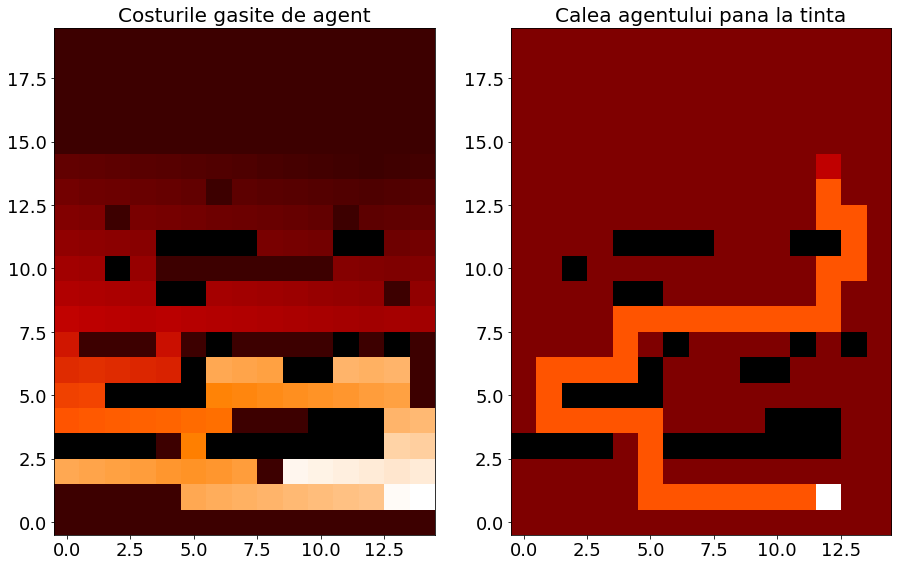



============================== LRTA* pe input2.txt cu euristica Manhattan ==============================
Nodurile din calea gasita:
[252, 233, 214, 215, 199, 179, 178, 167, 147, 146, 145, 144, 143, 142, 141, 140, 139, 129, 113, 112, 111, 110, 91, 75, 76, 77, 78, 79, 60, 43, 24, 25, 26, 27, 28, 29, 30, 31]
Pozitiile din calea gasita:
(14, 12) -> (13, 12) -> (12, 12) -> (12, 13) -> (11, 13) -> (10, 13) -> (10, 12) -> (9, 12) -> (8, 12) -> (8, 11) -> (8, 10) -> (8, 9) -> (8, 8) -> (8, 7) -> (8, 6) -> (8, 5) -> (8, 4) -> (7, 4) -> (6, 4) -> (6, 3) -> (6, 2) -> (6, 1) -> (5, 1) -> (4, 1) -> (4, 2) -> (4, 3) -> (4, 4) -> (4, 5) -> (3, 5) -> (2, 5) -> (1, 5) -> (1, 6) -> (1, 7) -> (1, 8) -> (1, 9) -> (1, 10) -> (1, 11) -> (1, 12)
Costul pana la tinta: 89
Timpul de rulare: 0.0072290380000001875 s
Memoria utilizata: 26.578125 KB


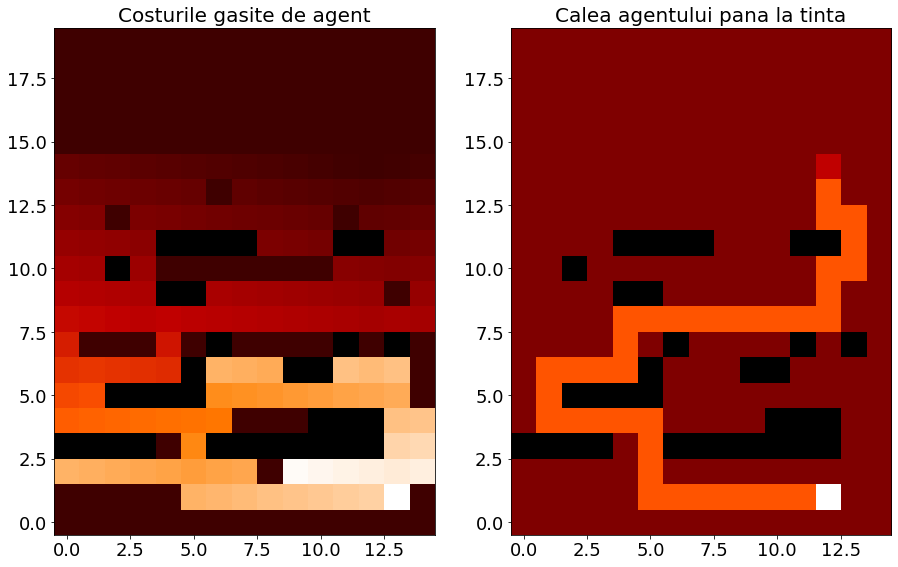



============================== LRTA* pe input2.txt cu euristica Weighthattan ==============================
Nodurile din calea gasita:
[252, 233, 214, 215, 199, 179, 178, 167, 147, 146, 145, 144, 143, 142, 141, 140, 139, 129, 113, 112, 111, 110, 91, 75, 76, 77, 78, 79, 60, 43, 24, 25, 26, 27, 28, 29, 30, 31]
Pozitiile din calea gasita:
(14, 12) -> (13, 12) -> (12, 12) -> (12, 13) -> (11, 13) -> (10, 13) -> (10, 12) -> (9, 12) -> (8, 12) -> (8, 11) -> (8, 10) -> (8, 9) -> (8, 8) -> (8, 7) -> (8, 6) -> (8, 5) -> (8, 4) -> (7, 4) -> (6, 4) -> (6, 3) -> (6, 2) -> (6, 1) -> (5, 1) -> (4, 1) -> (4, 2) -> (4, 3) -> (4, 4) -> (4, 5) -> (3, 5) -> (2, 5) -> (1, 5) -> (1, 6) -> (1, 7) -> (1, 8) -> (1, 9) -> (1, 10) -> (1, 11) -> (1, 12)
Costul pana la tinta: 89
Timpul de rulare: 0.007263839000000161 s
Memoria utilizata: 26.578125 KB


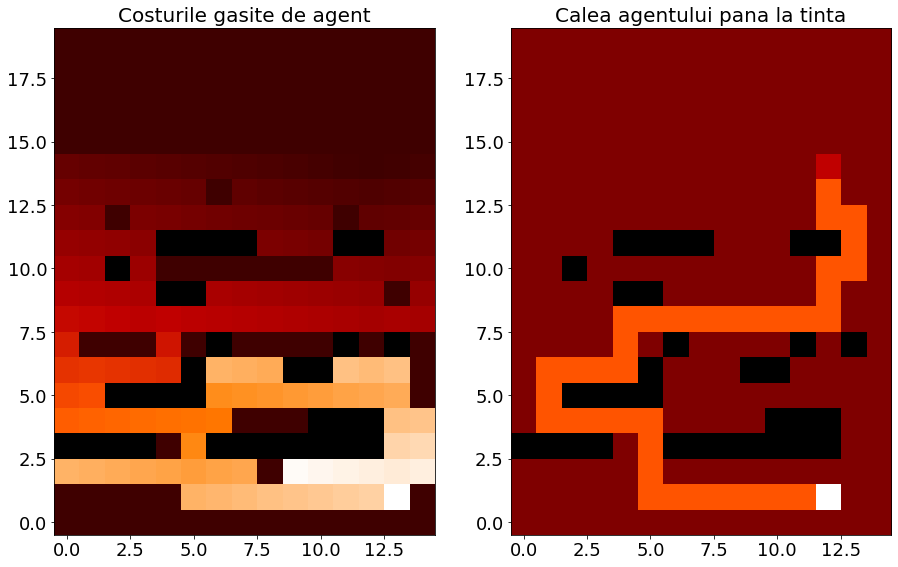



============================== LRTA* pe input3.txt cu euristica Euclid ==============================
Nodurile din calea gasita:
[1, 2, 3, 4, 5, 35, 65, 95, 125, 155, 185, 215, 245, 275, 305, 335, 365, 395, 425, 455, 485, 515, 545, 575, 605, 635, 665, 695, 725, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 736, 706, 676, 646, 645, 644, 643, 613, 583, 553, 554, 555, 556, 557, 558, 559, 560]
Pozitiile din calea gasita:
(0, 0) -> (0, 1) -> (0, 2) -> (0, 3) -> (0, 4) -> (1, 4) -> (2, 4) -> (3, 4) -> (4, 4) -> (5, 4) -> (6, 4) -> (7, 4) -> (8, 4) -> (9, 4) -> (10, 4) -> (11, 4) -> (12, 4) -> (13, 4) -> (14, 4) -> (15, 4) -> (16, 4) -> (17, 4) -> (18, 4) -> (19, 4) -> (20, 4) -> (21, 4) -> (22, 4) -> (23, 4) -> (24, 4) -> (25, 4) -> (25, 5) -> (25, 6) -> (25, 7) -> (25, 8) -> (25, 9) -> (25, 10) -> (25, 11) -> (25, 12) -> (25, 13) -> (25, 14) -> (25, 15) -> (24, 15) -> (23, 15) -> (22, 15) -> (21, 15) -> (21, 14) -> (21, 13) -> (21, 12) -> (20, 12) -> (19, 12) -> (18, 12) -> 

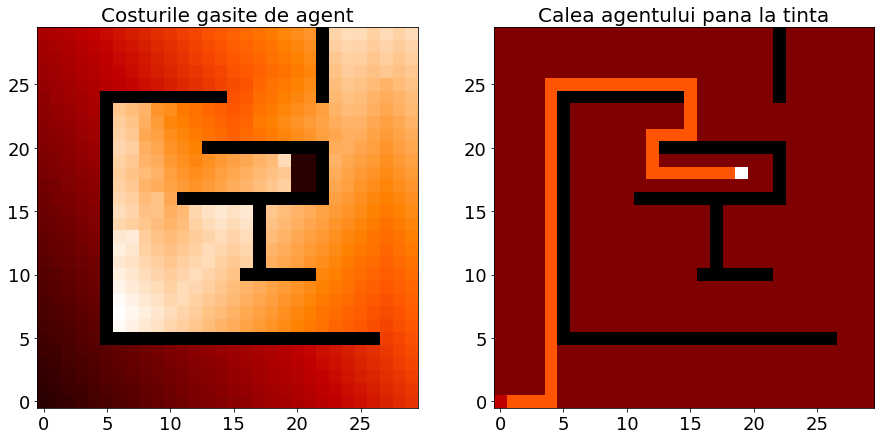



============================== LRTA* pe input3.txt cu euristica Manhattan ==============================
Nodurile din calea gasita:
[1, 2, 3, 4, 5, 35, 65, 95, 125, 155, 185, 215, 245, 275, 305, 335, 365, 395, 425, 455, 485, 515, 545, 575, 605, 635, 665, 695, 725, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 736, 706, 676, 646, 645, 644, 643, 613, 583, 553, 554, 555, 556, 557, 558, 559, 560]
Pozitiile din calea gasita:
(0, 0) -> (0, 1) -> (0, 2) -> (0, 3) -> (0, 4) -> (1, 4) -> (2, 4) -> (3, 4) -> (4, 4) -> (5, 4) -> (6, 4) -> (7, 4) -> (8, 4) -> (9, 4) -> (10, 4) -> (11, 4) -> (12, 4) -> (13, 4) -> (14, 4) -> (15, 4) -> (16, 4) -> (17, 4) -> (18, 4) -> (19, 4) -> (20, 4) -> (21, 4) -> (22, 4) -> (23, 4) -> (24, 4) -> (25, 4) -> (25, 5) -> (25, 6) -> (25, 7) -> (25, 8) -> (25, 9) -> (25, 10) -> (25, 11) -> (25, 12) -> (25, 13) -> (25, 14) -> (25, 15) -> (24, 15) -> (23, 15) -> (22, 15) -> (21, 15) -> (21, 14) -> (21, 13) -> (21, 12) -> (20, 12) -> (19, 12) -> (18, 12) 

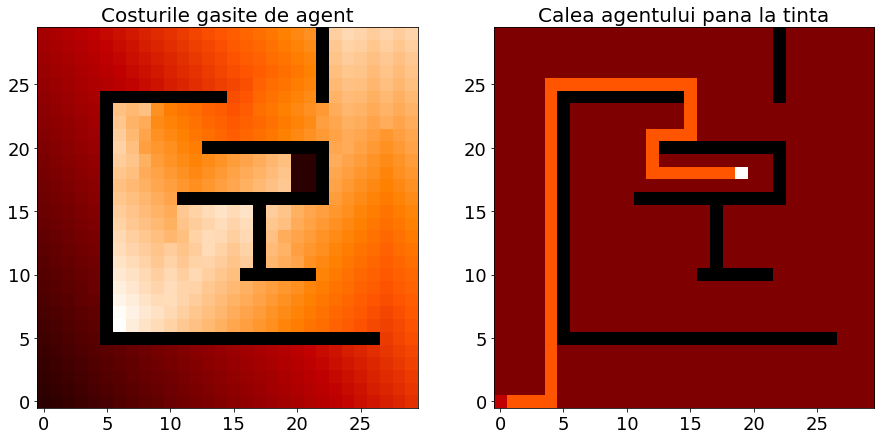



============================== LRTA* pe input3.txt cu euristica Weighthattan ==============================
Nodurile din calea gasita:
[1, 2, 3, 4, 5, 35, 65, 95, 125, 155, 185, 215, 245, 275, 305, 335, 365, 395, 425, 455, 485, 515, 545, 575, 605, 635, 665, 695, 725, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 736, 706, 676, 646, 645, 644, 643, 613, 583, 553, 554, 555, 556, 557, 558, 559, 560]
Pozitiile din calea gasita:
(0, 0) -> (0, 1) -> (0, 2) -> (0, 3) -> (0, 4) -> (1, 4) -> (2, 4) -> (3, 4) -> (4, 4) -> (5, 4) -> (6, 4) -> (7, 4) -> (8, 4) -> (9, 4) -> (10, 4) -> (11, 4) -> (12, 4) -> (13, 4) -> (14, 4) -> (15, 4) -> (16, 4) -> (17, 4) -> (18, 4) -> (19, 4) -> (20, 4) -> (21, 4) -> (22, 4) -> (23, 4) -> (24, 4) -> (25, 4) -> (25, 5) -> (25, 6) -> (25, 7) -> (25, 8) -> (25, 9) -> (25, 10) -> (25, 11) -> (25, 12) -> (25, 13) -> (25, 14) -> (25, 15) -> (24, 15) -> (23, 15) -> (22, 15) -> (21, 15) -> (21, 14) -> (21, 13) -> (21, 12) -> (20, 12) -> (19, 12) -> (18, 1

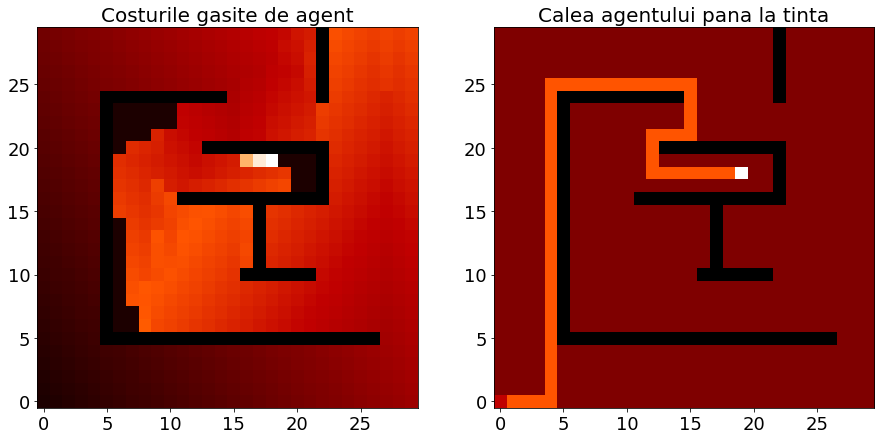

In [8]:
def _get_H(node, H, h, env):
    if node not in H:
        H[node] = h(env, node)

    return H[node]


def _lrta_traversal(env, node, H, h, path, costs):
    while node != env.target:
        l = [cost + _get_H(neigh, H, h, env)
            for neigh, cost in env.neighbours[node]]

        best_neigh, best_cost = env.neighbours[node][l.index(min(l))]
        H[node] = best_cost + H[best_neigh]
        path.append(best_neigh)

        new_neigh_cost = best_cost + costs[node]
        if best_neigh not in costs or costs[best_neigh] > new_neigh_cost:
            costs[best_neigh] = new_neigh_cost

        node = best_neigh


def lrta(env, h):
    H = {env.start: h(env, env.start)}
    costs = {env.start: 0}

    old_path = [0]
    new_path = [-1]

    while old_path != new_path:
        old_path = new_path
        path = [env.start]

        _lrta_traversal(env, env.start, H, h, path, costs)
        new_path = path

    return (new_path, costs)


for file in INPUT_FILES:
    for h_name, h_func in HEURISTICS.items():
        print(f"============================== LRTA* pe {basename(file)} cu euristica {h_name.capitalize()} ==============================")
        PERFORMANCE_METRICS["LRTA*"][basename(file)][h_name] = run(lrta, "LRTA*", file, h_func, h_name)
        print("\n")

# Bonus - Branch and Bound

============================== BnB pe input1.txt cu euristica Euclid ==============================
Nodurile din calea gasita:
[20, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 18, 27, 36, 45, 55, 64, 73, 82]
Pozitiile din calea gasita:
(2, 0) -> (1, 0) -> (0, 0) -> (0, 1) -> (0, 2) -> (0, 3) -> (0, 4) -> (0, 5) -> (0, 6) -> (0, 7) -> (0, 8) -> (1, 8) -> (2, 8) -> (3, 8) -> (4, 8) -> (5, 8) -> (6, 8) -> (7, 8) -> (8, 8)
Costul pana la tinta: 18
Timpul de rulare: 0.00045267000000048796 s
Memoria utilizata: 29.1015625 KB


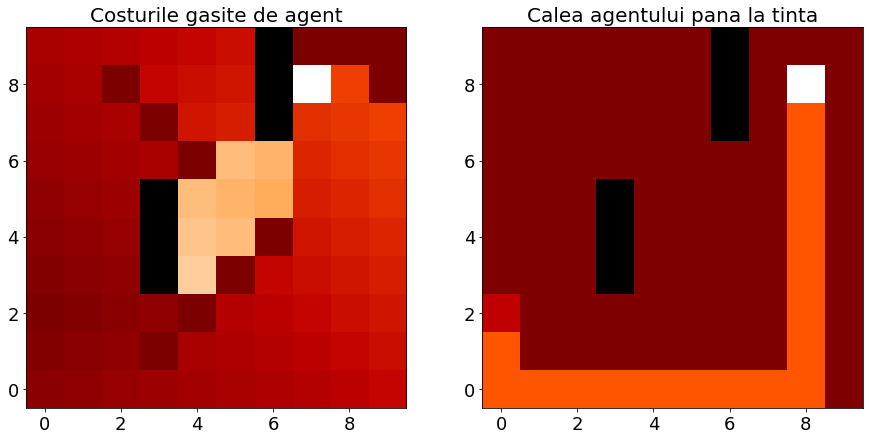



============================== BnB pe input1.txt cu euristica Manhattan ==============================
Nodurile din calea gasita:
[20, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 18, 27, 36, 45, 55, 64, 73, 82]
Pozitiile din calea gasita:
(2, 0) -> (1, 0) -> (0, 0) -> (0, 1) -> (0, 2) -> (0, 3) -> (0, 4) -> (0, 5) -> (0, 6) -> (0, 7) -> (0, 8) -> (1, 8) -> (2, 8) -> (3, 8) -> (4, 8) -> (5, 8) -> (6, 8) -> (7, 8) -> (8, 8)
Costul pana la tinta: 18
Timpul de rulare: 0.00021265900000067006 s
Memoria utilizata: 9.140625 KB


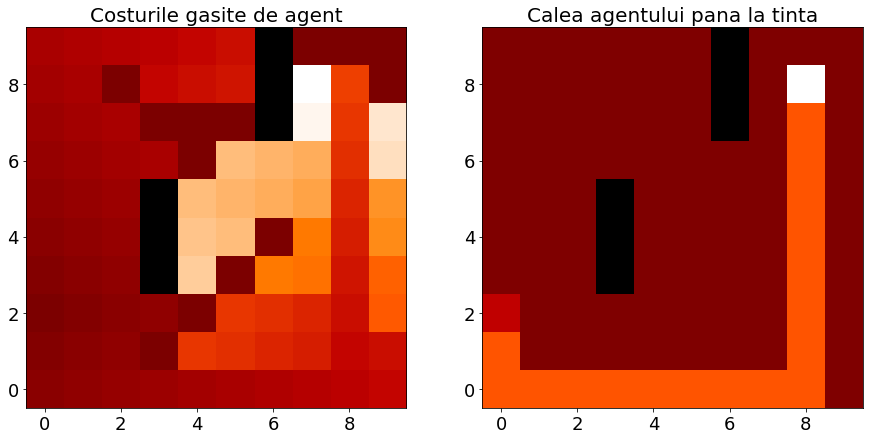



============================== BnB pe input1.txt cu euristica Weighthattan ==============================
Nodurile din calea gasita:
[20, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 18, 27, 36, 45, 55, 64, 73, 82]
Pozitiile din calea gasita:
(2, 0) -> (1, 0) -> (0, 0) -> (0, 1) -> (0, 2) -> (0, 3) -> (0, 4) -> (0, 5) -> (0, 6) -> (0, 7) -> (0, 8) -> (1, 8) -> (2, 8) -> (3, 8) -> (4, 8) -> (5, 8) -> (6, 8) -> (7, 8) -> (8, 8)
Costul pana la tinta: 18
Timpul de rulare: 0.0002285180000001219 s
Memoria utilizata: 11.0966796875 KB


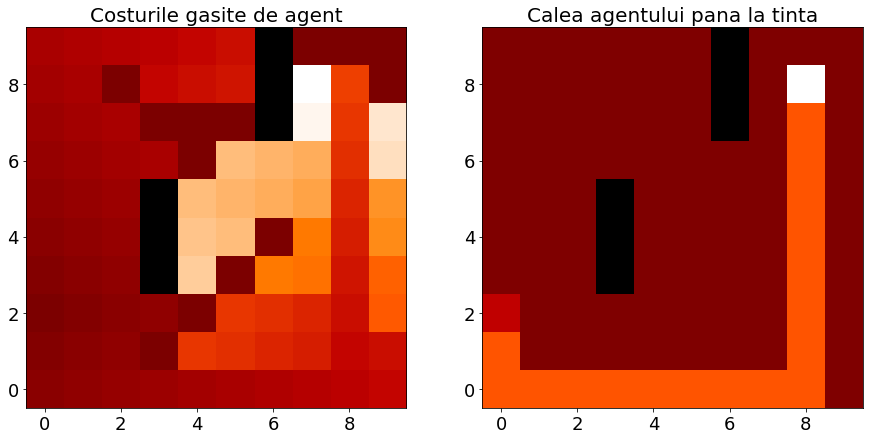



============================== BnB pe input2.txt cu euristica Euclid ==============================
Nodurile din calea gasita:
[252, 251, 250, 249, 248, 247, 246, 245, 244, 243, 242, 241, 240, 222, 204, 186, 173, 155, 135, 128, 109, 110, 91, 75, 76, 77, 78, 79, 60, 43, 44, 45, 26, 27, 28, 29, 30, 31]
Pozitiile din calea gasita:
(14, 12) -> (14, 11) -> (14, 10) -> (14, 9) -> (14, 8) -> (14, 7) -> (14, 6) -> (14, 5) -> (14, 4) -> (14, 3) -> (14, 2) -> (14, 1) -> (14, 0) -> (13, 0) -> (12, 0) -> (11, 0) -> (10, 0) -> (9, 0) -> (8, 0) -> (7, 0) -> (6, 0) -> (6, 1) -> (5, 1) -> (4, 1) -> (4, 2) -> (4, 3) -> (4, 4) -> (4, 5) -> (3, 5) -> (2, 5) -> (2, 6) -> (2, 7) -> (1, 7) -> (1, 8) -> (1, 9) -> (1, 10) -> (1, 11) -> (1, 12)
Costul pana la tinta: 89
Timpul de rulare: 0.003940114000000605 s
Memoria utilizata: 60.5927734375 KB


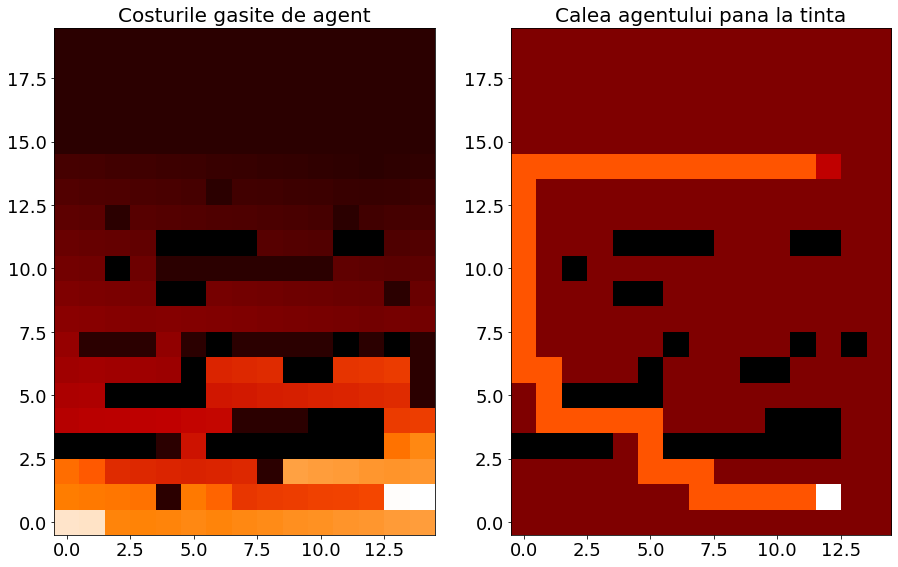



============================== BnB pe input2.txt cu euristica Manhattan ==============================
Nodurile din calea gasita:
[252, 251, 250, 249, 248, 247, 246, 245, 244, 243, 242, 241, 240, 222, 204, 186, 173, 155, 135, 128, 109, 110, 91, 75, 76, 77, 78, 79, 60, 43, 44, 45, 26, 27, 28, 29, 30, 31]
Pozitiile din calea gasita:
(14, 12) -> (14, 11) -> (14, 10) -> (14, 9) -> (14, 8) -> (14, 7) -> (14, 6) -> (14, 5) -> (14, 4) -> (14, 3) -> (14, 2) -> (14, 1) -> (14, 0) -> (13, 0) -> (12, 0) -> (11, 0) -> (10, 0) -> (9, 0) -> (8, 0) -> (7, 0) -> (6, 0) -> (6, 1) -> (5, 1) -> (4, 1) -> (4, 2) -> (4, 3) -> (4, 4) -> (4, 5) -> (3, 5) -> (2, 5) -> (2, 6) -> (2, 7) -> (1, 7) -> (1, 8) -> (1, 9) -> (1, 10) -> (1, 11) -> (1, 12)
Costul pana la tinta: 89
Timpul de rulare: 0.004124438999999924 s
Memoria utilizata: 35.671875 KB


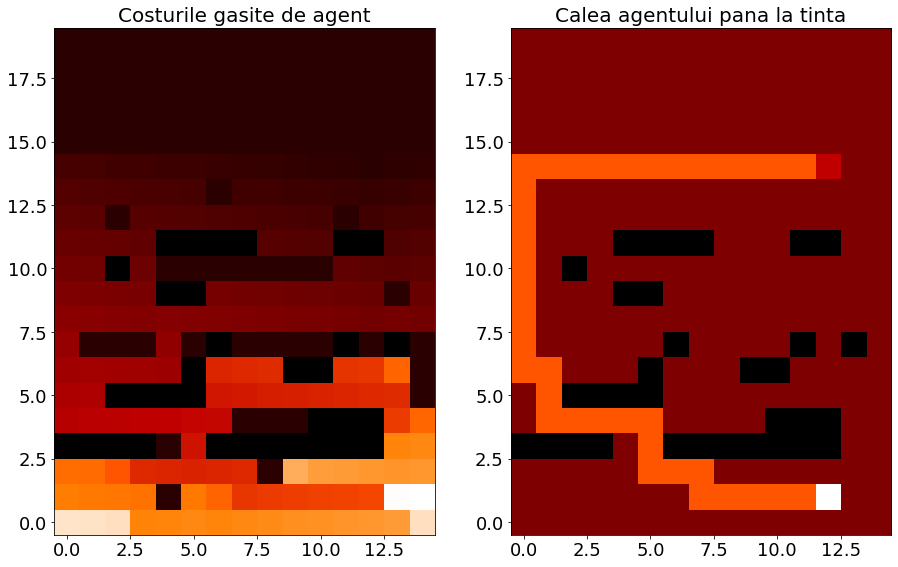



============================== BnB pe input2.txt cu euristica Weighthattan ==============================
Nodurile din calea gasita:
[252, 251, 250, 249, 248, 247, 246, 245, 244, 243, 242, 241, 240, 222, 204, 186, 173, 155, 135, 128, 109, 110, 91, 75, 76, 77, 78, 79, 60, 43, 44, 45, 26, 27, 28, 29, 30, 31]
Pozitiile din calea gasita:
(14, 12) -> (14, 11) -> (14, 10) -> (14, 9) -> (14, 8) -> (14, 7) -> (14, 6) -> (14, 5) -> (14, 4) -> (14, 3) -> (14, 2) -> (14, 1) -> (14, 0) -> (13, 0) -> (12, 0) -> (11, 0) -> (10, 0) -> (9, 0) -> (8, 0) -> (7, 0) -> (6, 0) -> (6, 1) -> (5, 1) -> (4, 1) -> (4, 2) -> (4, 3) -> (4, 4) -> (4, 5) -> (3, 5) -> (2, 5) -> (2, 6) -> (2, 7) -> (1, 7) -> (1, 8) -> (1, 9) -> (1, 10) -> (1, 11) -> (1, 12)
Costul pana la tinta: 89
Timpul de rulare: 0.0028047690000008174 s
Memoria utilizata: 35.7265625 KB


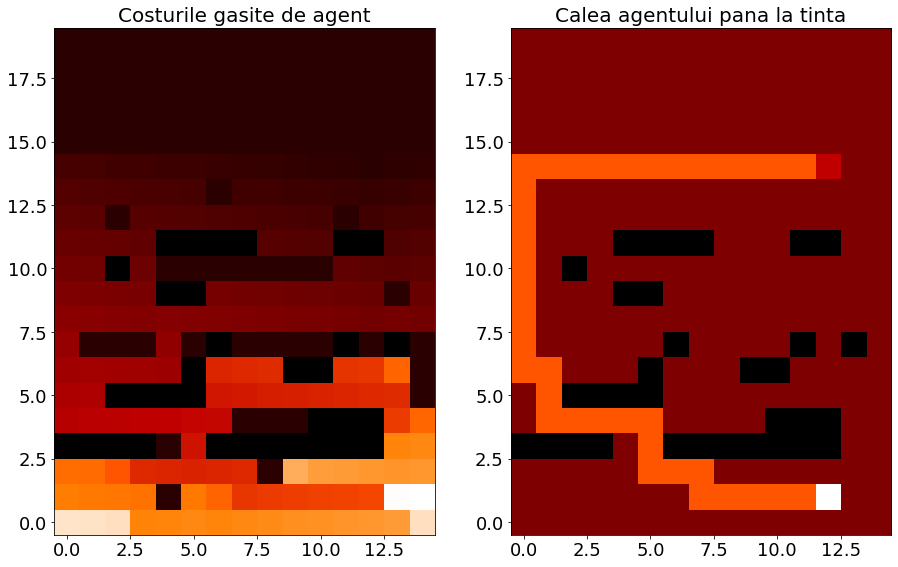



============================== BnB pe input3.txt cu euristica Euclid ==============================
Nodurile din calea gasita:
[1, 31, 61, 91, 121, 151, 181, 211, 241, 271, 301, 331, 361, 391, 421, 451, 481, 511, 541, 571, 601, 631, 661, 691, 721, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 736, 706, 676, 646, 645, 644, 643, 613, 583, 553, 554, 555, 556, 557, 558, 559, 560]
Pozitiile din calea gasita:
(0, 0) -> (1, 0) -> (2, 0) -> (3, 0) -> (4, 0) -> (5, 0) -> (6, 0) -> (7, 0) -> (8, 0) -> (9, 0) -> (10, 0) -> (11, 0) -> (12, 0) -> (13, 0) -> (14, 0) -> (15, 0) -> (16, 0) -> (17, 0) -> (18, 0) -> (19, 0) -> (20, 0) -> (21, 0) -> (22, 0) -> (23, 0) -> (24, 0) -> (25, 0) -> (25, 1) -> (25, 2) -> (25, 3) -> (25, 4) -> (25, 5) -> (25, 6) -> (25, 7) -> (25, 8) -> (25, 9) -> (25, 10) -> (25, 11) -> (25, 12) -> (25, 13) -> (25, 14) -> (25, 15) -> (24, 15) -> (23, 15) -> (22, 15) -> (21, 15) -> (21, 14) -> (21, 13) -> (21, 12) -> (20, 12) -> (19, 12) -> (1

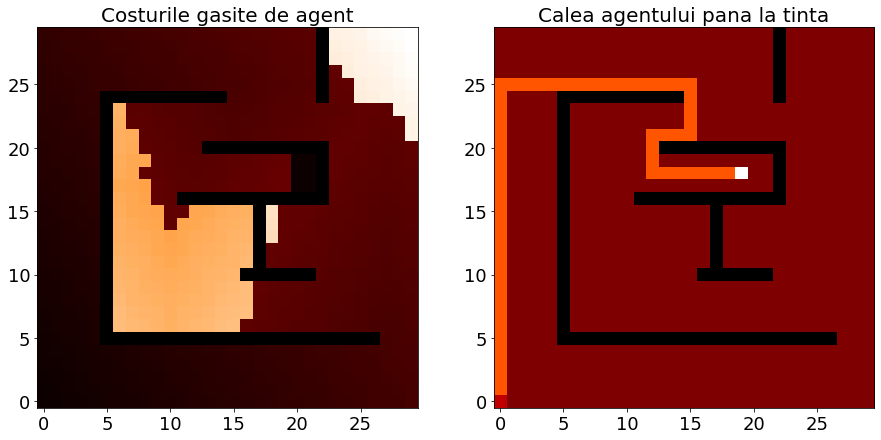



============================== BnB pe input3.txt cu euristica Manhattan ==============================
Nodurile din calea gasita:
[1, 31, 61, 91, 121, 151, 181, 211, 241, 271, 301, 331, 361, 391, 421, 451, 481, 511, 541, 571, 601, 631, 661, 691, 721, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 736, 706, 676, 646, 645, 644, 643, 613, 583, 553, 554, 555, 556, 557, 558, 559, 560]
Pozitiile din calea gasita:
(0, 0) -> (1, 0) -> (2, 0) -> (3, 0) -> (4, 0) -> (5, 0) -> (6, 0) -> (7, 0) -> (8, 0) -> (9, 0) -> (10, 0) -> (11, 0) -> (12, 0) -> (13, 0) -> (14, 0) -> (15, 0) -> (16, 0) -> (17, 0) -> (18, 0) -> (19, 0) -> (20, 0) -> (21, 0) -> (22, 0) -> (23, 0) -> (24, 0) -> (25, 0) -> (25, 1) -> (25, 2) -> (25, 3) -> (25, 4) -> (25, 5) -> (25, 6) -> (25, 7) -> (25, 8) -> (25, 9) -> (25, 10) -> (25, 11) -> (25, 12) -> (25, 13) -> (25, 14) -> (25, 15) -> (24, 15) -> (23, 15) -> (22, 15) -> (21, 15) -> (21, 14) -> (21, 13) -> (21, 12) -> (20, 12) -> (19, 12) ->

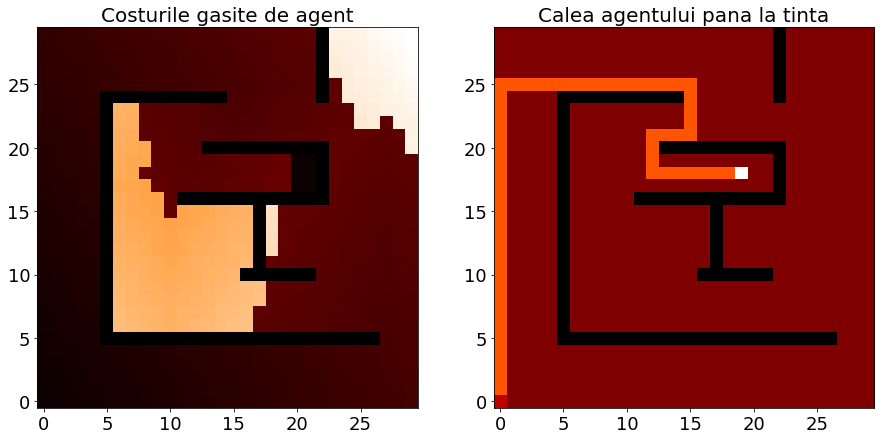



============================== BnB pe input3.txt cu euristica Weighthattan ==============================
Nodurile din calea gasita:
[1, 31, 61, 91, 121, 151, 181, 211, 241, 271, 301, 331, 361, 391, 421, 451, 481, 511, 541, 571, 601, 631, 661, 691, 721, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 736, 706, 676, 646, 645, 644, 643, 613, 583, 553, 554, 555, 556, 557, 558, 559, 560]
Pozitiile din calea gasita:
(0, 0) -> (1, 0) -> (2, 0) -> (3, 0) -> (4, 0) -> (5, 0) -> (6, 0) -> (7, 0) -> (8, 0) -> (9, 0) -> (10, 0) -> (11, 0) -> (12, 0) -> (13, 0) -> (14, 0) -> (15, 0) -> (16, 0) -> (17, 0) -> (18, 0) -> (19, 0) -> (20, 0) -> (21, 0) -> (22, 0) -> (23, 0) -> (24, 0) -> (25, 0) -> (25, 1) -> (25, 2) -> (25, 3) -> (25, 4) -> (25, 5) -> (25, 6) -> (25, 7) -> (25, 8) -> (25, 9) -> (25, 10) -> (25, 11) -> (25, 12) -> (25, 13) -> (25, 14) -> (25, 15) -> (24, 15) -> (23, 15) -> (22, 15) -> (21, 15) -> (21, 14) -> (21, 13) -> (21, 12) -> (20, 12) -> (19, 12)

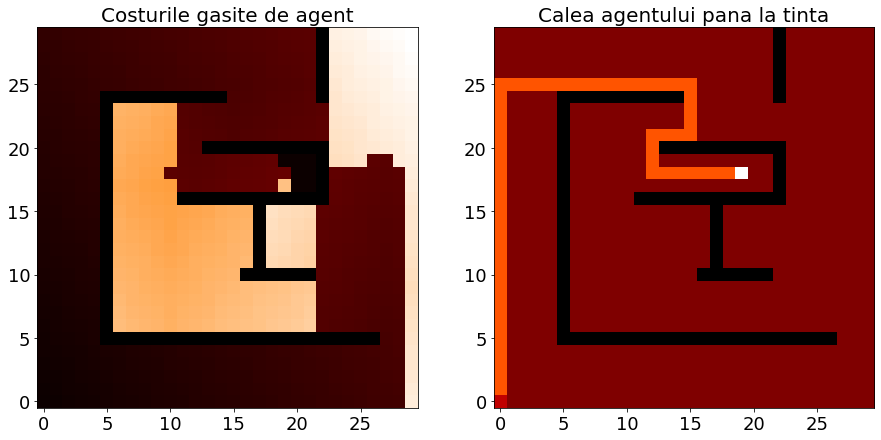

In [9]:
from copy import deepcopy


def _build_path_cost(node, visited):
    path = []
    while node:
        path.append(node)
        node = visited[node][1]
    
    path.reverse()
    return path, {n: c for n, (c, _) in visited.items()}


def _bnb_traversal(env, node, cost, h, visited):
    global limit

    if node == env.target:
        limit = cost
        return

    for neigh, edge_cost in sorted(env.neighbours[node], key=lambda x: x[1]):
        neigh_cost = cost + edge_cost
        if (neigh in visited and visited[neigh][0] <= neigh_cost
            or neigh_cost + h(env, neigh) >= limit
        ):
            continue

        visited[neigh] = (neigh_cost, node)
        _bnb_traversal(env, neigh, neigh_cost, h, visited)


def bnb(env, h):
    global limit

    limit = inf
    visited = {env.start: (0, None)}

    _bnb_traversal(env, env.start, 0, h, visited)

    return _build_path_cost(env.target, visited)


for file in INPUT_FILES:
    for h_name, h_func in HEURISTICS.items():
        print(f"============================== BnB pe {basename(file)} cu euristica {h_name.capitalize()} ==============================")
        PERFORMANCE_METRICS["BnB"][basename(file)][h_name] = run(bnb, "BnB", file, h_func, h_name)
        print("\n")

# Grafice cu timpii de executie si memoria utilizata

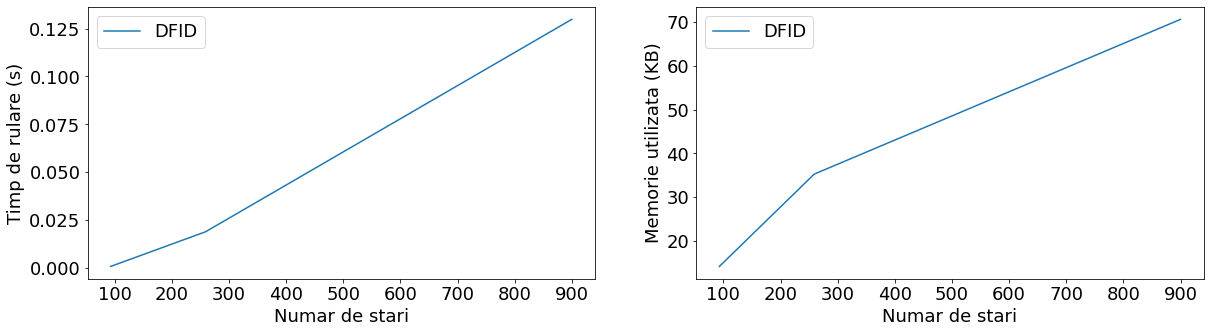

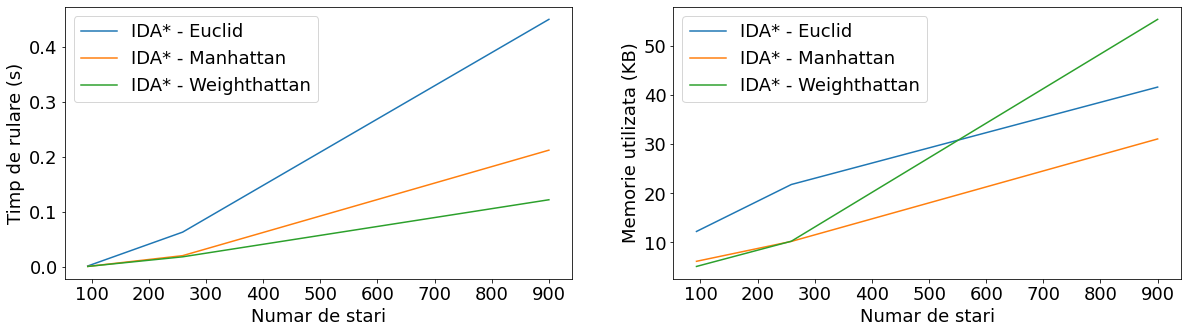

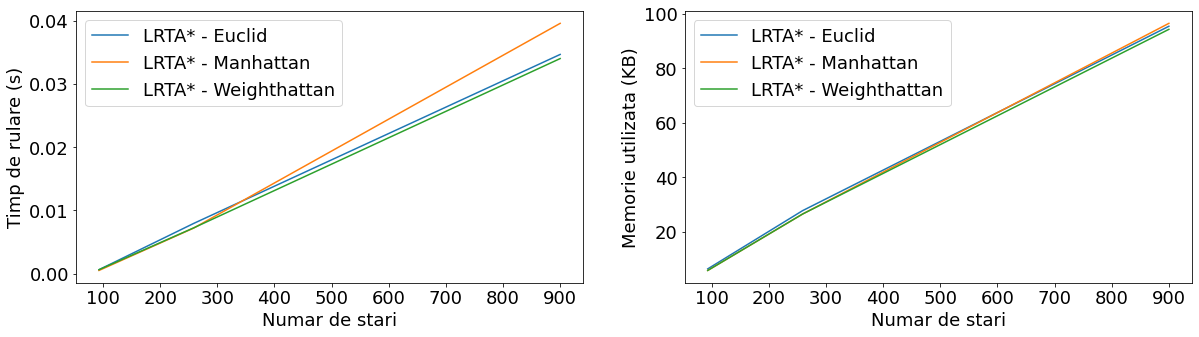

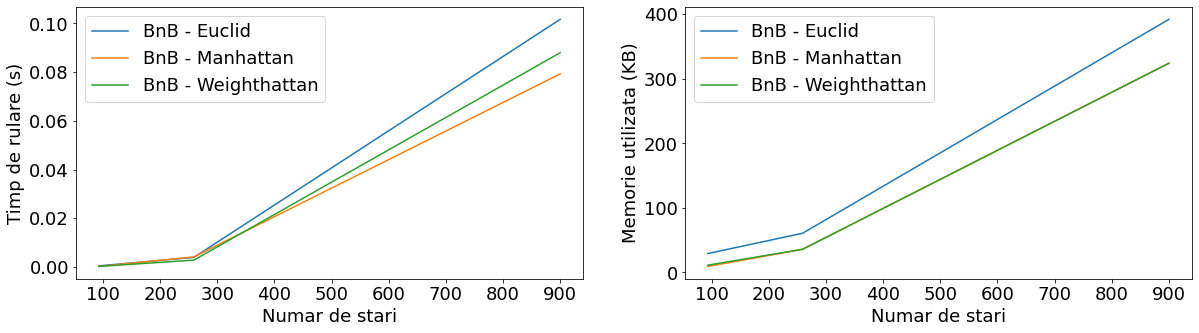

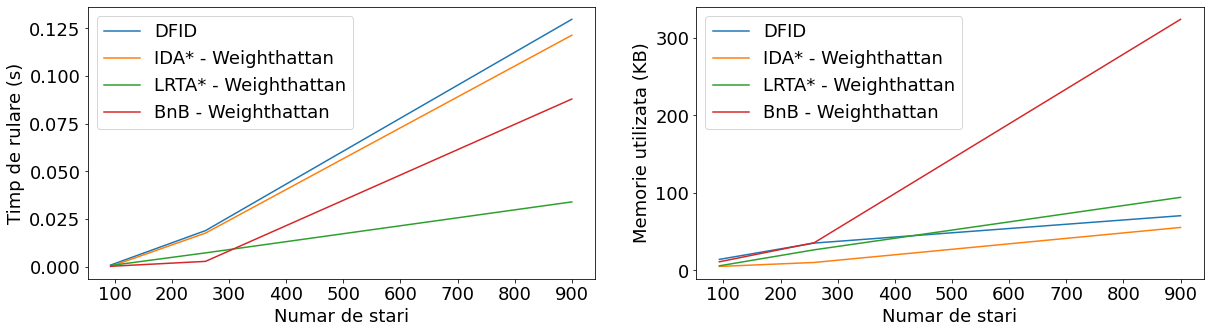

In [10]:
import json


num_nodes = list(map(lambda e: len(e.neighbours) + len(e.obsts), ENVS.values()))
all_times = []
all_mems = []
all_labels = []


def plot_metric(axis, data, labels, ylabel):
    for i in range(len(data)):
        axis.plot(num_nodes, data[i], label=labels[i])
    
    axis.set_xlabel("Numar de stari", fontsize=18)
    axis.set_ylabel(ylabel, fontsize=18)
    axis.legend(fontsize=18)


def plot_time_mem_heur():
    for alg_name, metrics in list(PERFORMANCE_METRICS.items())[1:]:
        labels = [f"{alg_name} - {key.capitalize()}"
            for key in HEURISTICS.keys()]
        all_labels.append(f"{alg_name} - Weighthattan")
        
        times = []
        mems = []

        for heur in HEURISTICS.keys():
            t, m = zip(*[heurs[heur] for heurs in metrics.values()])
            times.append(t)
            mems.append(m)

            if heur == "weighthattan":
                all_times.append(t)
                all_mems.append(m)

        _, axes = plt.subplots(1, 2, figsize=(20, 5))
        plot_metric(axes[0], times, labels,
            "Timp de rulare (s)")
        plot_metric(axes[1], mems, labels,
            "Memorie utilizata (KB)")
        
        plt.show()

dfid_times, dfid_mems = zip(*PERFORMANCE_METRICS["DFID"].values())
all_times.append(dfid_times)
all_mems.append(dfid_mems)
all_labels.append("DFID")

_, axes = plt.subplots(1, 2, figsize=(20, 5))

plot_metric(axes[0], [dfid_times], ["DFID"], "Timp de rulare (s)")
plot_metric(axes[1], [dfid_mems], ["DFID"], "Memorie utilizata (KB)")

plot_time_mem_heur()

_, axes = plt.subplots(1, 2, figsize=(20, 5))
plot_metric(axes[0], all_times, all_labels, "Timp de rulare (s)")
plot_metric(axes[1], all_mems, all_labels, "Memorie utilizata (KB)")
plt.show()